In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Loading Data 

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()
all_data = pd.concat([train_data, test_data])
train_data.shape, test_data.shape, all_data.shape

((891, 12), (418, 11), (1309, 12))

# Data Exploration

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# it is useful to split into numeric and categorical data for better visualization using historgrams and bar charts
numeric_df = train_data[['Age', 'SibSp', 'Fare', 'Parch']]
cat_df = train_data[['Survived', 'Embarked', 'Sex', 'Pclass', 'Cabin']]

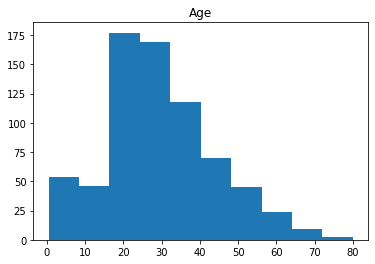

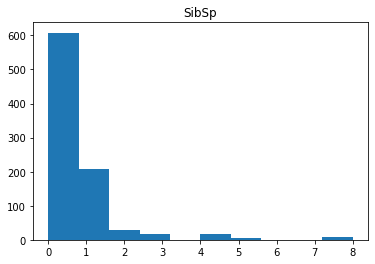

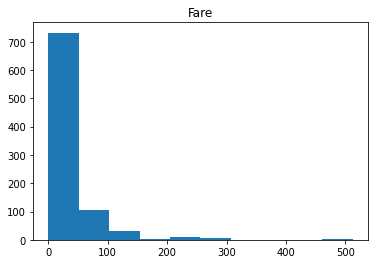

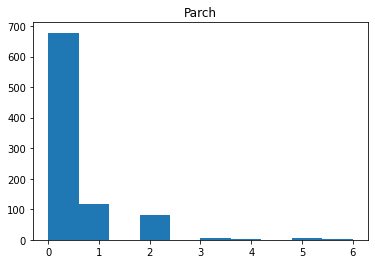

In [6]:
for col in numeric_df.columns:
    plt.hist(numeric_df[col])
    plt.title(col)
    plt.show()

            Age     SibSp      Fare     Parch
Age    1.000000 -0.308247  0.096067 -0.189119
SibSp -0.308247  1.000000  0.159651  0.414838
Fare   0.096067  0.159651  1.000000  0.216225
Parch -0.189119  0.414838  0.216225  1.000000


<AxesSubplot:>

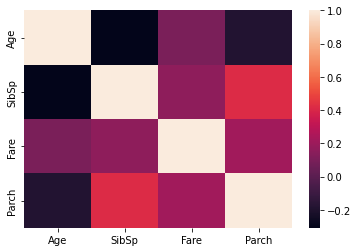

In [7]:
print (numeric_df.corr())
sns.heatmap(numeric_df.corr())

In [8]:
# compare the survival rate across Age, Fare, Parch, SibSp
pd.pivot_table(train_data, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


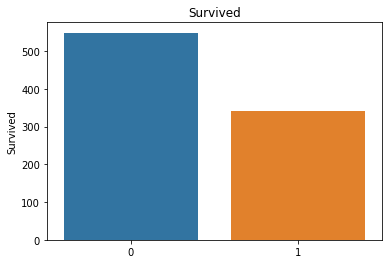

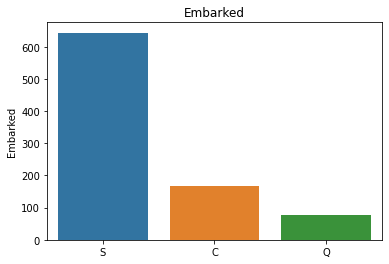

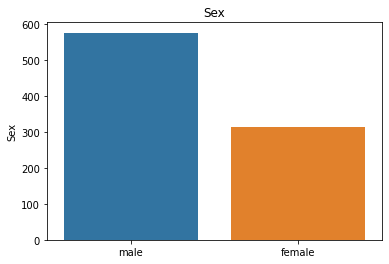

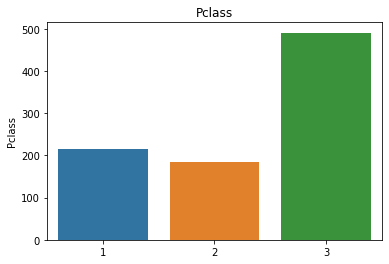

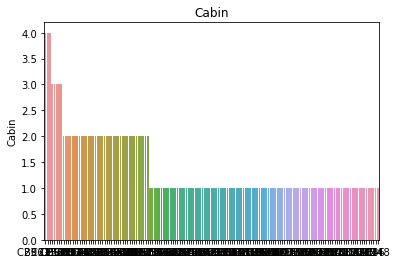

In [9]:
for col in cat_df.columns:
    # plt.title(col)
    sns.barplot(x=cat_df[col].value_counts().index, y=cat_df[col].value_counts()).set_title(col)
    plt.show()

# Data Cleaning

0      2.110213
1      4.280593
2      2.188856
3      3.990834
4      2.202765
         ...   
413    2.202765
414    4.699571
415    2.110213
416    2.202765
417    3.150952
Name: norm_fare, Length: 1307, dtype: float64

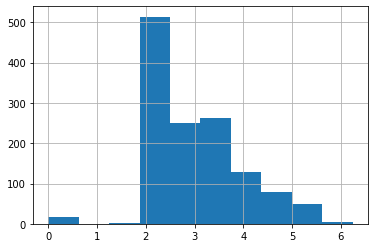

In [10]:
# drop/fill null values
all_data.dropna(subset=['Embarked'], inplace=True)

# fill the null values using the mean
all_data.Age = all_data.Age.fillna(train_data.Age.mean())
all_data.Fare = all_data.Fare.fillna(train_data.Fare.mean())

# normalize Fare 
all_data['norm_fare'] = np.log(all_data.Fare+1)
#all_data.Fare.hist()
all_data.norm_fare.hist()
all_data.norm_fare.fillna(all_data.norm_fare.mean())

# Feature Engineering

In [11]:
# adding the cabin_adv feature column from Cabin
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,norm_fare,cabin_adv
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,n
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,n
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.202765,n


# Data Pre-processing for Modelling

In [12]:
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_adv', 'Survived' ]])
all_dummies


,Pclass,Age,SibSp,Parch,norm_fare,Survived,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
0,3,22.000000,1,0,2.110213,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,38.000000,1,0,4.280593,1.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,26.000000,0,0,2.188856,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,35.000000,1,0,3.990834,1.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,35.000000,0,0,2.202765,0.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,29.699118,0,0,2.202765,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,1
414,1,39.000000,0,0,4.699571,NaN,1,0,1,0,0,0,0,1,0,0,0,0,0,0
415,3,38.500000,0,0,2.110213,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,1
416,3,29.699118,0,0,2.202765,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [13]:
# split x_train, x_test
train_idx = (all_dummies['Survived']==0) | (all_dummies['Survived']==1)
x_train = all_dummies[train_idx]
y_train = all_dummies[train_idx]['Survived']
x_test = all_dummies[~train_idx]
x_train.shape, y_train.shape, x_test.shape

((889, 20), (889,), (418, 20))

In [14]:
x_train = x_train.drop(columns=['Survived'])
x_train

,Pclass,Age,SibSp,Parch,norm_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
0,3,22.000000,1,0,2.110213,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,38.000000,1,0,4.280593,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,26.000000,0,0,2.188856,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,35.000000,1,0,3.990834,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,35.000000,0,0,2.202765,0,1,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,2.639057,0,1,0,0,1,0,0,0,0,0,0,0,0,1
887,1,19.000000,0,0,3.433987,1,0,0,0,1,0,1,0,0,0,0,0,0,0
888,3,29.699118,1,2,3.196630,1,0,0,0,1,0,0,0,0,0,0,0,0,1
889,1,26.000000,0,0,3.433987,0,1,1,0,0,0,0,1,0,0,0,0,0,0


# Modelling 

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn

SyntaxError: invalid syntax (3326548911.py, line 6)

## Naive Bayes

In [ ]:
gnb = GaussianNB()
cross_val_score(gnb, x_train, y_train, cv=5)


## Random Forest

In [ ]:
rf = RandomForestClassifier()
cross_val_score(rf, x_train, y_train, cv=5)

## XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
cross_val_score(xgb_model, x_train, y_train, cv=5)

# Submission

In [ ]:
submission_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
rf.fit(x_train, y_train)
y_test = rf.predict(x_test)


In [ ]:
y_test

In [ ]:
submission_df['Survived'] = y_test.astype('int64')

In [ ]:
submission_df.to_csv('submission.csv', index=False)